# Embeddings: What Are They and When to Use Them?

## Intro

Working with high-demensional data can be a challenge. If we can reduce the number of dimensions to a reasonable number, it will really make our life easier - whether we want detect a meaningful pattern or use this data as a feature in a model. That's where an *embedding* is coming handy.

An embedding is a low-dimensional representation of high-dimensional data. There exist many specialized embeddings for particular data structures, for example:
- PCA and ICA for numerical data,
- word2vec and BERT for text data,
- Fourier descriptors for shape image data.

Here, we will discuss how we can use embeddings in a very general setting: our data can have an arbitrary nature - be it numbers, vectors, graphs, text or images - and we only thing we know is how to compare two samples from this data. In other words, we can define *similarity* or *dissimilarity* matrix. 

Embeddings this we will cover:
- PCA (of course!)
- Locally Linear Embedding (LLE)
- Kernel PCA
- Spectral embedding
- Multidimensional Scaling (MDS)

The list is not complete but it is not meant to. Rather then going through every single embedding over there, we will focus on how we can apply embeddings to solve real-world problems. Then you can use your own favourite linear or non-linear embedding to tackle the problem that you have.

We will also tackle pros and cons of this method. Yes, this method has a few cons: its generality doesn't come for free. Sometimes you may be better off using a specialied embedding instead or not using any embedding at all. Unfortunately, a method that is great at at absolutely everything in Machine Learning has not been discovered yet... If it has and I missed it - please do let me know! =)

## Similarity and Dissimilarity matrices

Similarity and dissimilarity matrices serve to a similar (pun time!) purpose: to define how similar (or dissimilar) any two objects in our data are.

**Similarity matrix** for data with $n$ samples is a $(n,n)$ matrix $S$, where element $S_{ij}$ contains similarity measure between samples $i$ and $j$.
- Higher numbers indicate similar samples.
- For example, for numerical data radial basis kernel is often used: $S_{ij}=\exp{-\frac{|x_i-x_j|^2}{2\sigma^2}}$.

**Dissimilarity matrix** is a $(n,n)$ matrix $D$, here element $S_{ij}$ contains dissimilarity measure between samples $i$ and $j$.
- It is "the opposite" of similarity matrix: lower numbers indicate similar samples.
- For numerical data, any metric could be used. However, it doesn't have to be a metric (triangle inequality may not hold), which is very convenient if we deal with non-numerical data.
- We can convert any dissimilarity matrix to similarity matrix or via versa (e.g., by subtracting it from a diagonal matrix, or by computing radial kernel)

Okay, the main math part is over. Let's go, it's Machine Learning time!

---
Some unnecessarily technical moments:
1. Usually, similarity and dissimilarity matrices are assumed to be positive semi-definite.
2. A kernel matrix required for Kernel PCA and SVM can be proxied by applying kernel to dissimilarity matrix. This is, however, just a convenient approximation.

# Primer on Embeddings with 2D Spatial Data

First, let's see how embedding methods work on very simple 2D data. Specifically,
- Can an embedding discover the underlying data structure and groups within the dataset?
- Will a 1D-embedding be able to reduce data dimensionality without significant information loss?

---

2D is already as low-dimentional as it gets. In reality, you probably won't need to use embeddings to deal with this kind of data - it's just useful to get some intuition of how it works.

In [16]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA, KernelPCA
from sklearn.manifold import SpectralEmbedding, MDS, LocallyLinearEmbedding, Isomap
from sklearn.cluster import KMeans
import sys
from loguru import logger

np.random.seed(42**3)
plt.style.use('seaborn')
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['figure.figsize'] = (6, 3)
logger.remove()
logger.add(sys.stderr, format='{time} {level} {line}: {message}', level='DEBUG')

def gen_2d_v1(c, r1, r2, r3):
    dx, dy = r3*np.sin(r2*np.pi*2), r3*np.cos(r2*np.pi*2)
    if c == 0:
        return np.cos(r1*np.pi)+dy, np.sin(r1*np.pi)-0.2+dx
    elif c == 1:
        return np.cos(r1*np.pi)+1.2+dy, np.sin(-r1*np.pi)+0.2+dx
    elif c == 2:
        return np.cos(r1*np.pi)+2.4+dy, np.sin(r1*np.pi)-0.2+dx
    elif c == 3:
        return np.cos(r1*np.pi)+3.6+dy, np.sin(-r1*np.pi)+0.2+dx
    else:
        raise ValueError(f'Category "{c}" is not recognized')
        

def gen_2d_v2(c, r1, r2, r3):
    dx, dy = r3*np.sin(r2*np.pi*2), r3*np.cos(r2*np.pi*2)
    if c == 0:
        return np.cos(r1*np.pi)+dy, np.sin(r1*np.pi)-0.2+dx
    elif c == 1:
        return np.cos(r1*np.pi)+1.2+dy, np.sin(-r1*np.pi)+0.2+dx
    elif c == 2:
        return 1.2*np.sin(r1*np.pi*2)+4+dx, 1.2*np.cos(r1*np.pi*2)+dy
    elif c == 3:
        return 0.7*np.sin(r1*np.pi*2)+4+dx, 0.7*np.cos(r1*np.pi*2)+dy
    else:
        raise ValueError(f'Category "{c}" is not recognized')


def generate_2d_data(n, dispersion, version='v1'):
    categories=np.random.choice(range(4), size=n)
    rvs1=np.random.rand(n)
    rvs2=np.random.rand(n)
    rvs3=np.random.exponential(scale=dispersion, size=n)
    if version == 'v1':
        gen_fun = gen_2d_v1
    elif version == 'v2':
        gen_fun = gen_2d_v2
    else:
        raise ValueError(f'Version "{version}" is not recognized')
    x, y = zip(*(gen_fun(c, r1, r2, r3) for c, r1, r2, r3 in zip(categories, rvs1, rvs2, rvs3)))
    df = pd.DataFrame(dict(
        cat=categories,
        x=x,
        y=y,
    ))
    return df

colormap = {0: 'magenta', 1: 'pink', 2: 'navy', 3: 'blue'}

def plot_2d_data(data, title='True', ax=None):
    data.plot(
        kind='scatter', x='x', y='y', alpha=0.5, color=data['cat'].map(colormap), ax=ax,
        title=f'2D spatial data: {title}'
    )

def plot_2d_data_embedding(data, embedding_obj, title, ax=None):
    X_ = embedding_obj.fit_transform(data[['x', 'y']])
    X_ = pd.DataFrame(X_, index=data.index, columns=[str(c) for c in range(X_.shape[1])])
    if X_.shape[1] == 1:
        X_['1'] = 0
    X_.plot(
        kind='scatter', x='0', y='1', alpha=0.5, color=data['cat'].map(colormap), ax=ax,
        title=f'2D spatial data embedding: {title}'
    )

def plot_2d_data_all(data1, data2, data3, data4):
    fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharey=True)
    fig.set_tight_layout(True)
    plot_2d_data(data1, ax=ax[0, 0])
    plot_2d_data(data2, ax=ax[0, 1])
    plot_2d_data(data3, ax=ax[1, 0])
    plot_2d_data(data4, ax=ax[1, 1])
    
def plot_2d_data_embedding_all(data_list, embedding_obj, title):
    n = len(data_list)
    fig, ax = plt.subplots(n, 3, figsize=(n*3, 10), sharey=True)
    fig.set_tight_layout(True)
    for i, data in enumerate(data_list):
        plot_2d_data(data, ax=ax[i, 0])
        embedding_obj.set_params(n_components=1)
        plot_2d_data_embedding(data, embedding_obj, title + ' (1)', ax=ax[i, 1])
        embedding_obj.set_params(n_components=2)
        plot_2d_data_embedding(data, embedding_obj, title + ' (2)', ax=ax[i, 2])

## 2D spacial dataset

I've generated four 2D datasets with 4 distinct groups in each:
- dataset with four arcs,
- dataset with two arcs and two circles,
- noisy versions of the datasets above.

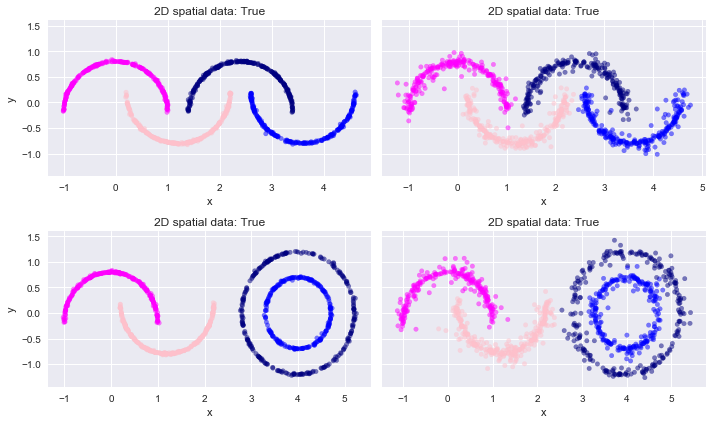

In [2]:
data_v1_simple = generate_2d_data(1000, dispersion=0.01, version='v1')
data_v1_hard = generate_2d_data(1000, dispersion=0.08, version='v1')
data_v2_simple = generate_2d_data(1000, dispersion=0.01, version='v2')
data_v2_hard = generate_2d_data(1000, dispersion=0.08, version='v2')
data_all = (data_v1_simple, data_v1_hard, data_v2_simple, data_v2_hard)

plot_2d_data_all(data_v1_simple, data_v1_hard, data_v2_simple, data_v2_hard)

## Embeddings

Let's see how embeddings work on these four datasets. For each embeddings, I set the output number of dimensions to 1 or 2 (the initial number of dementions is 2).

### PCA

**Idea:** Find a linear transformation of features that 
- maximizes captured variance of features or, equivalently,
- minimizes quadratic reconstruction error.

**Pros:**
- It is quite robust to noise in data.

**Cons:**
- It only captures linear structures.

Wall time: 833 ms


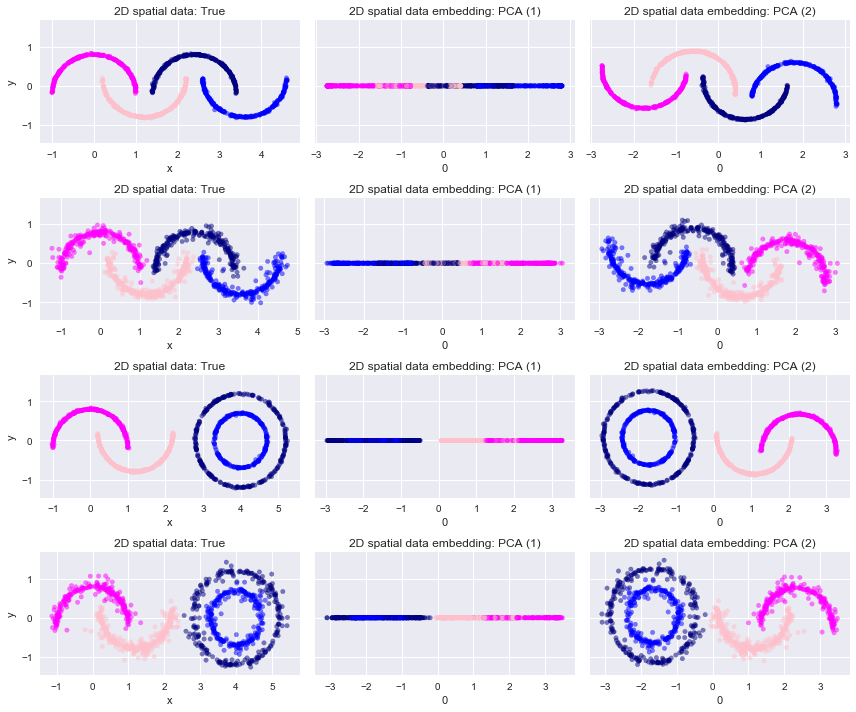

In [3]:
%%time
plot_2d_data_embedding_all(data_all, PCA(), 'PCA')

### Locally Linear Embedding (LLE)

**Idea:** Find a transformation that preserces local affine structure.

**Pros:**
- It captures locally linear structures - but globally it's non-linear.

**Cons:**
- It is sensitive to noise in data.

Wall time: 2.63 s


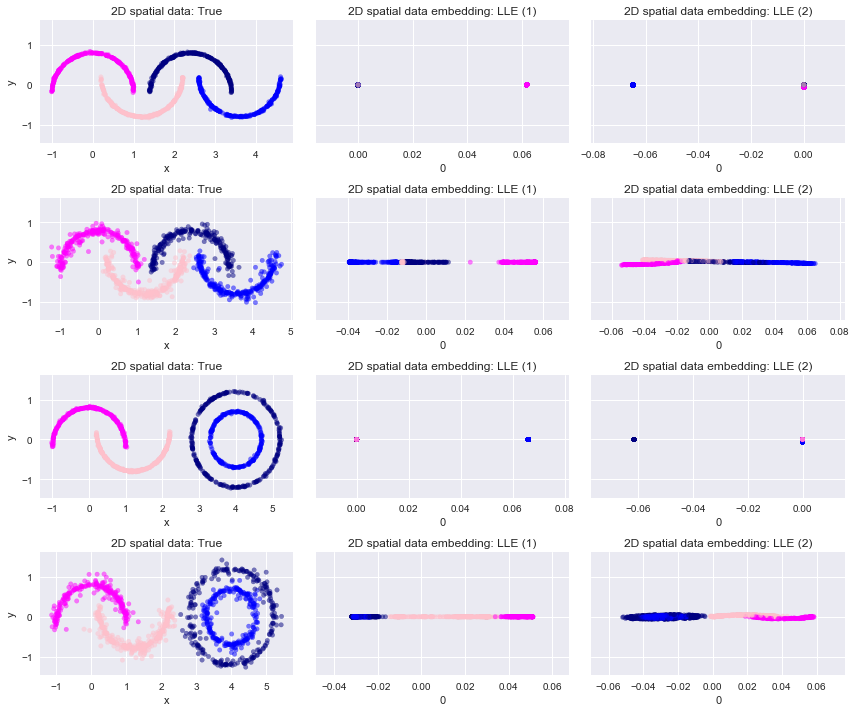

In [4]:
%%time
plot_2d_data_embedding_all(data_all, LocallyLinearEmbedding(n_neighbors=10, method='modified'), 'LLE')

### Kernel PCA

**Idea:** Apply a variation of PCA to kernel matrix.

**Pros:**
- It can capture non-linear structures.
- It is designed to work with kernel matrix. If only dissimilarity matrix is available (like in the use case later), we use proxy it by applying kernel to dissimilarity matrix.

**Cons:**
- It is very sensitive to the choice of distance.

Wall time: 1.61 s


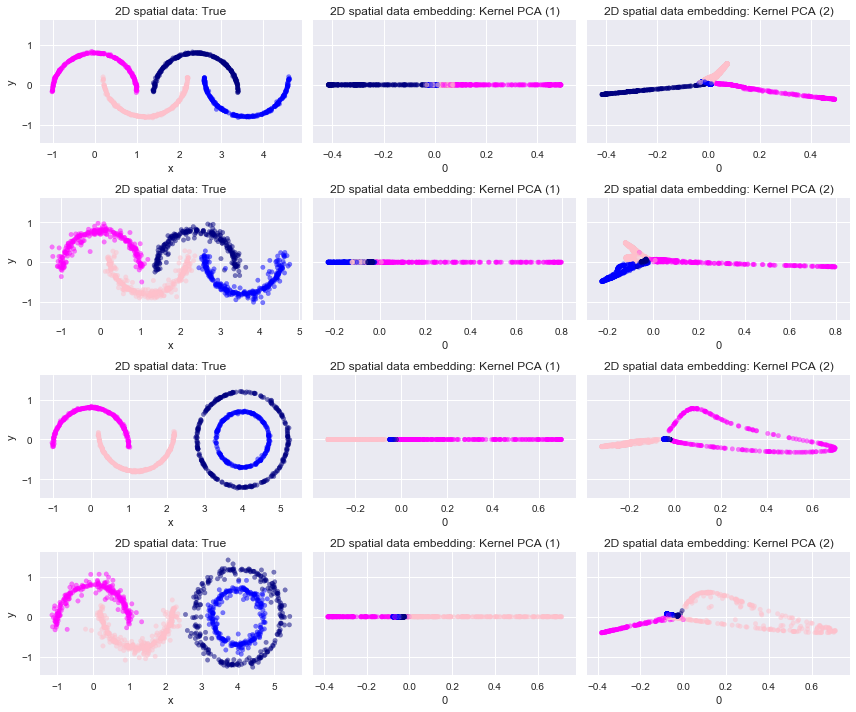

In [5]:
%%time
# high gamma => smaller local neighberhoods
plot_2d_data_embedding_all(data_all, KernelPCA(kernel='rbf', gamma=10), 'Kernel PCA')

### Spectral Embedding

**Idea:** Replace similarity matrix with similarity graph (e.g., by setting edges of distant points to zero).

**Pros:**
- It is explicitely designed to work with similarity matrix.
- It can capure non-linear structures.
- Here, it shows good separation of the four groups of points.

**Cons:**
- It is sensitive to noise in data.
- Scikit-learn can't transform out-of-sample data (although it is possible in principle$^{[1]}$).

---

1. [Out-of-Sample Extensions for LLE, Isomap,. MDS, Eigenmaps, and Spectral Clustering. Yoshua Bengio, Jean-François Paiement, Pascal Vincent.](https://papers.nips.cc/paper/2461-out-of-sample-extensions-for-lle-isomap-mds-eigenmaps-and-spectral-clustering.pdf)

d:\softwarework\pythonprojects\env\ds\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
d:\softwarework\pythonprojects\env\ds\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
d:\softwarework\pythonprojects\env\ds\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
d:\softwarework\pythonprojects\env\ds\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connect

Wall time: 3.53 s


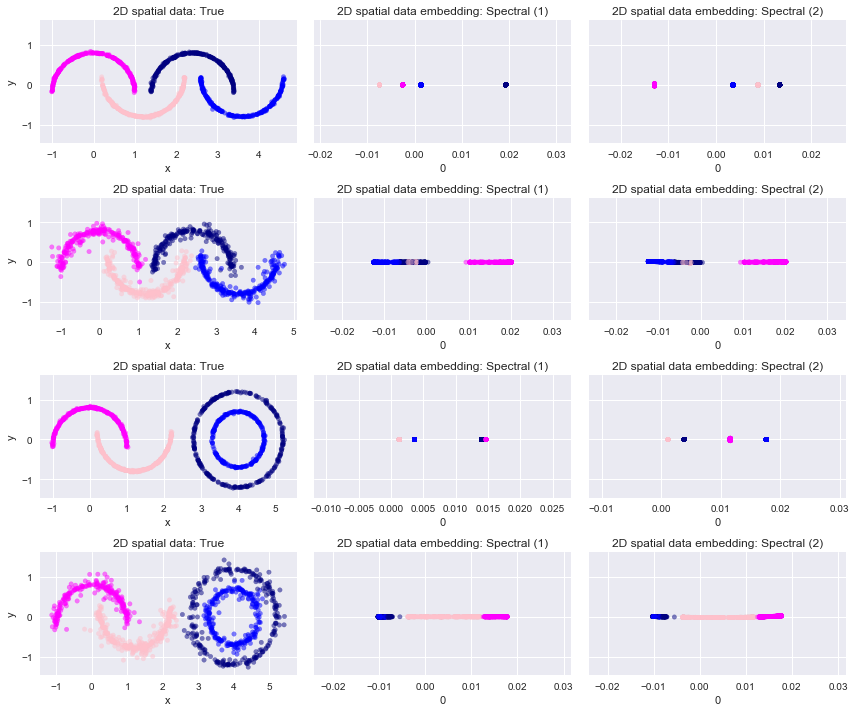

In [6]:
%%time
# high n_neighbors => larger local neighberhoods
plot_2d_data_embedding_all(data_all, SpectralEmbedding(affinity='nearest_neighbors', n_neighbors=10), 'Spectral')

### Multidimensional Scaling (MDS)

**Idea:** Find representation that preserves distances between samples globally.

**Pros:**
- It is explicitely designed to work with dissimilarity matrix.
- It preserves distances globally so it should not be much affected by noise in data.

**Cons:**
- It does not simplify separation of groups (although, it's not the goal of this method).
- This method is very slow.
- Scikit-learn can't transform out-of-sample data (although it is possible in principle$^{[1]}$).

---

1. [Out-of-Sample Extensions for LLE, Isomap,. MDS, Eigenmaps, and Spectral Clustering. Yoshua Bengio, Jean-François Paiement, Pascal Vincent.](https://papers.nips.cc/paper/2461-out-of-sample-extensions-for-lle-isomap-mds-eigenmaps-and-spectral-clustering.pdf)

Wall time: 1min 53s


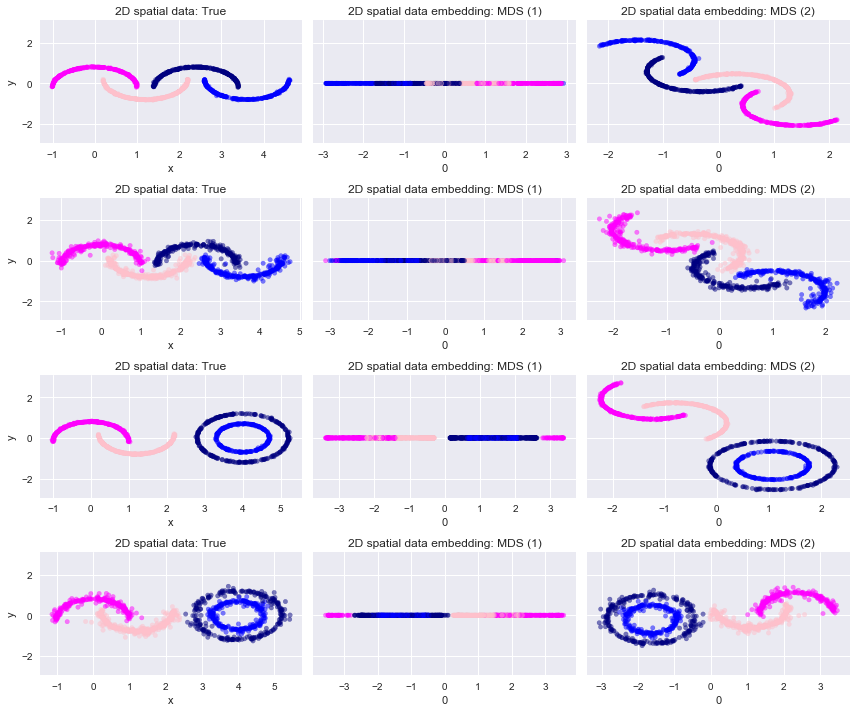

In [7]:
%%time
plot_2d_data_embedding_all(data_all, MDS(metric=True), 'MDS')

### How did we do?

Well, our only goal here was to see how embeddings work, and this is what we saw:
- Non-linear embeddings (LLE, Kernel PCA and Spectral) can be quite good at separating low-dimensional manifolds in data: useful if you need to find non-spherical clusters.
- Non-linear embeddings (LLE, Kernel PCA and Spectral) are sensitive to noise in data.
    - Takeaway: clean data first. For example, we could remove points that have less then 5 neighbours withing a certain distance.
- Linear embeddings (PCA) are quick and rubost to noisy data but may not be as efficient as non-linear embeddings on clean data.
- MDS is a good option if you like to preserve distances globally. It's also very slow so it may not be a viable option for large datasets.
- Scikit-learn does not support out-of-sample transformation for Spectral Embedding and MDS, which make them less convenient to be used for classification or regression.

**The overall message.** Different embeddings have different objectives and limitations. Choose the one that is right for your sprcific problem!

# Use case: Trade Routes

Let's consider the following problem: a few cities on a small tropical island have developped trade routes. We've been tracking all package shipments on the island for some time now. We'd like to know:
- What are the main trade routes on the island?
- Can we predict destination of a package that is currently on its route?

The data that we collected is high-deminsional: for every tracked shipment we have an ordered list of xy-coordinates where we saw the package (starting from its first and ending with its last observed locations). If we have 50 observations - we have a vector with 50 points, which is 100 dimensions (and, by the way, we cannot compare two such vectors using Euclidean metric). But if all packages are shipped through only a few routes, the effictive dimensionality is probably much lower. 

Well, it sounds like just the right task for embeddings! We only need to find a way to compare to package shipments...

---

You might ask yourself, "Is it really important that we are on a small tropical island?" And the answer is: yes, definitely! If we were on a big icy peninsula, this problem would have been solved completely differently. 

In [377]:
from mpl_toolkits.mplot3d import Axes3D

def gen_path_curve(first, last, max_curve, step, reverse):
    n = int((last-first) / step)
    angles = np.cumsum(np.random.rand(n+1))
    angles = angles[:-1] / angles[-1]
    angles = (first + angles * (last-first))
    angles = angles * np.pi
    x = (1 - np.cos(angles)) / 2
    if reverse:
        x = 1 - x
    y = np.sin(angles) * max_curve
    return x, y

def similarity(x, y, x0, y0, x1, y1):
    l = np.sqrt((x1-x0) ** 2 + (y1-y0) ** 2)
    cos = (x1-x0) / l
    sin = (y1-y0) / l
    x_ = x0 + l * (cos * x - sin * y)
    y_ = y0 + l * (sin * x + cos * y)
    return x_, y_

def add_noise(x, y, noise_sigma):
    n = len(x)
    noise_r = np.random.normal(scale=noise_sigma, size=n)
    noise_angle = np.random.rand(n)
    x = x + noise_r*np.sin(noise_angle*np.pi*2)
    y = y + noise_r*np.cos(noise_angle*np.pi*2)
    return x, y

def gen_rand_path_curve(x0, y0, x1, y1, step, max_curve, max_curve_sigma, noise_sigma, partial_proba, reverse=False, 
                        first=0, last=1, partial_min=0.3):
    assert first < last
    if np.random.rand() < partial_proba:
        a, b = np.random.uniform(first, last-partial_min), np.random.uniform(first, last-partial_min)
        first = min(a, b)
        last = max(a, b) + partial_min
    max_curve = max_curve + np.random.normal(scale=max_curve_sigma)
    step = step / np.sqrt((x1-x0) ** 2 + (y1-y0) ** 2) / np.sqrt(1 + (2*max_curve_sigma) ** 2)
    x, y = gen_path_curve(first, last, max_curve, step, reverse)
    x, y = similarity(x, y, x0, y0, x1, y1)
    x, y = add_noise(x, y, noise_sigma)
    return x, y

def generate_path_data(n, max_curve_sigma, noise_sigma, partial_proba, partial_min=0.3, step=0.02):
    p = [1, 1, 1, 1, 1, 1, 1]
    categories = np.random.choice(range(len(p)), p=p/np.sum(p), size=n)
    xy_list = []
    sigma_kwargs = dict(
        max_curve_sigma=max_curve_sigma, 
        noise_sigma=noise_sigma, 
        partial_proba=partial_proba, 
        partial_min=partial_min,
    )
    for i, cat in enumerate(categories):
        if cat == 0:
            x, y = gen_rand_path_curve(x0=0, y0=0, x1=0, y1=1, max_curve=-0.5, step=step, **sigma_kwargs)
            start, end = 0, 1
        elif cat == 1:
            x, y = gen_rand_path_curve(x0=0, y0=0, x1=0, y1=1, max_curve=-0.5, step=step, reverse=True, **sigma_kwargs)    
            start, end = 1, 0
        elif cat == 2:
            x, y = gen_rand_path_curve(x0=1, y0=0, x1=1, y1=1, max_curve=0.5, step=step, **sigma_kwargs)
            start, end = 3, 2
        elif cat == 3:
            x, y = gen_rand_path_curve(x0=0, y0=0, x1=1, y1=1, max_curve=0.05, step=step, **sigma_kwargs)
            start, end = 0, 2
        elif cat == 4:
            x, y = gen_rand_path_curve(x0=0, y0=0, x1=1, y1=1, max_curve=0.05, step=step, reverse=True, **sigma_kwargs)
            start, end = 2, 0
        elif cat == 5:
            x, y = gen_rand_path_curve(x0=1, y0=1, x1=1, y1=0, max_curve=-0.1, step=step, **sigma_kwargs)
            start, end = 2, 3
        elif cat == 6:
            x, y = gen_rand_path_curve(x0=0, y0=1, x1=1, y1=0, max_curve=0.2, step=step, **sigma_kwargs)
            start, end = 1, 3
        else:
            raise ValueError(f'Category "{cat}" is not recognized')
        xy_list.append({'cat': cat, 'xy': np.vstack((x, y)).T, 'start': start, 'end': end})
    return xy_list

colormap2 = {0: 'magenta', 1: 'darkgreen', 2: 'navy', 3: 'deepskyblue', 4: 'orange', 5: 'red', 6: 'pink'}

def plot_path_data(path_data, title, ax, colorblind=False, annotations=True):
    for path in path_data:
        color = 'blue' if colorblind else colormap2[path['cat']] 
        pd.DataFrame(path['xy'], columns=['x', 'y']).plot(
            kind='line', x='x', y='y', alpha=0.5, color=color, ax=ax, legend=False,
        )
        ax.set_title(f'Path data: {title}', fontsize=14)
    if annotations:
        ax.annotate('0', (0, 0), (0.1, 0.1), size=14, weight='bold', arrowprops={'facecolor': 'black', 'width': 1})
        ax.annotate('1', (0, 1), (0.1, 1-0.1), size=14, weight='bold', arrowprops={'facecolor': 'black', 'width': 1})
        ax.annotate('2', (1, 1), (1-0.1, 1-0.1), size=14, weight='bold', arrowprops={'facecolor': 'black', 'width': 1})
        ax.annotate('3', (1, 0), (1-0.1, 0.1), size=14, weight='bold', arrowprops={'facecolor': 'black', 'width': 1})

## Shipment data

I've generated two datasets: one rather clean and on rather noisy. Everything else is the same:
- There are 4 main points where the shipments start or end. Let's call them "trade posts" and number from 0 to 3.
- There are 5 trade routes in total, and 2 of them are bi-directional: 
    - the curved one between trade posts 0 and 1
    - the straight one between trade posts 0 and 2
- Our observations are not perfect:
    - We don't always have a full shipment path: sometimes, we only manage to track some points in the middle of the route.
    - Our observations are 100% accurate: they are usually off by relatively small distance.

In [122]:
%%time
path_data_simple = generate_path_data(
    n=200, max_curve_sigma=0.02, noise_sigma=0.01, partial_proba=0.3, step=0.02
)
path_data_hard = generate_path_data(
    n=200, max_curve_sigma=0.04, noise_sigma=0.02, partial_proba=0.7, step=0.02
)

2020-04-19T09:46:32.240465+0100 INFO 19: data is created and dumped to data\path_data_simple.pickle
2020-04-19T09:46:32.269457+0100 INFO 19: data is created and dumped to data\path_data_hard.pickle


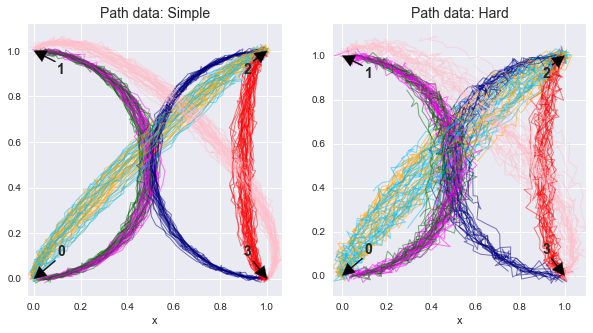

In [394]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_path_data(path_data_simple, 'Simple', ax=ax[0])
plot_path_data(path_data_hard, 'Hard', ax=ax[1])

# How to detect main trading routes?

We have observations of numerous shipments on the island. How do we understand what the main trading routes are?

This is what we can do:
1. We choose distance measure between two paths.
2. We compute dissimilarity matrix (then similarity matrix, if necessary).
3. We apply an embedding on the matrix.

By analyzing the embedding, we can then segment the trading routes.

> Homework. Instead of analyzing embedding plots with a naked eye, use a clusterization method to separate the main trading routes. Verify how accurate the clusters are (you couldn't do it in the real world but here you "magically" know the ground truth).

You might be asking yourself, "Why do we need to detect anything? All trading routes have been nicely colored on the previous plot already." Well, true. As we generated the dataset, we happened to "magically" know all this information. But in reality, we wouldn't be that lucky. Also, if we had 100 trading posts instead of 4, analysis of data with a naked eye only would prove a little more challenging.

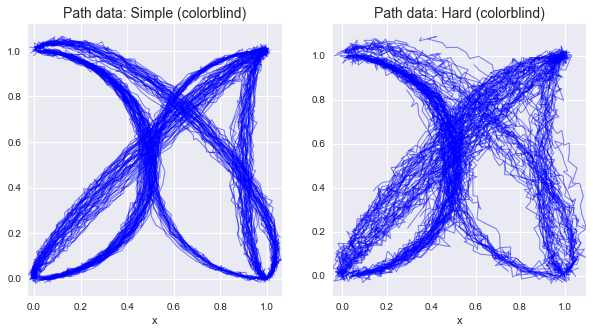

In [395]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_path_data(path_data_simple, 'Simple (colorblind)', ax=ax[0], colorblind=True, annotations=False)
plot_path_data(path_data_hard, 'Hard (colorblind)', ax=ax[1], colorblind=True, annotations=False)

## Dissimilarity matrix

How to compute distance between two shipments? Unfortunately, is not as trivial as computing Euclidean distance between shipment route vectors. The routes may have different number of observations and different spacing between any two observations. Because of this, it's not clear how we should match the observed shipment points.

Luckily, there exists just the right distance for this case! It's called Frechet distance. From [wiki](https://en.wikipedia.org/wiki/Fr%C3%A9chet_distance):

*Imagine a man traversing a finite curved path while walking his dog on a leash, with the dog traversing a separate one. Each can vary their speed to keep slack in the leash, but neither can move backwards. The Fréchet distance between the two curves is the length of the shortest leash sufficient for both to traverse their separate paths.*

Frechet distance is sensitive to direction of the travel. However, it's easy to modify it so it's not. Should we? Let's see:
- If we only care about trade route locations, we can ignore shipment's route direction.
- If we care who is importing to whom, we should take ship shipment's direction into account.

We can see that computing dissimilarity matrix using Frechet distance can take a while, which is not too surprising: we need to compute $O(n^2)$ distances, and each distance takes $O(k^2 \log{k})$ iterations, where $n$ is the number of routes and $k$ is the number of points in a route. Still, using `numba` helped to make computational time more or less reasonable.

In [309]:
from numba import njit

@njit
def minkowski_distance_(x, y, p=2):
    return np.sum(np.abs(y-x)**p, axis=-1)**(1./p)

@njit
def frechet_dist(exp_data, num_data, p=2):
    n = len(exp_data)
    m = len(num_data)
    ca = -np.ones((n, m))
    ca[0, 0] = minkowski_distance_(exp_data[0], num_data[0], p=p)
    for i in range(1, n):
        ca[i, 0] = max(ca[i-1, 0], minkowski_distance_(exp_data[i], num_data[0], p=p))
    for j in range(1, m):
        ca[0, j] = max(ca[0, j-1], minkowski_distance_(exp_data[0], num_data[j], p=p))
    for i in range(1, n):
        for j in range(1, m):
            ca[i, j] = max(min(ca[i-1, j], ca[i, j-1], ca[i-1, j-1]),
                           minkowski_distance_(exp_data[i], num_data[j], p=p))
    return ca[n-1, m-1]

path 1 - path 2 distance: 0.50
path 1 - path 3 distance: 1.00
path 1 - path 4 distance: 0.90
path 1 - path 5 distance: 1.29
Wall time: 48 ms


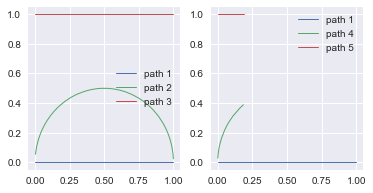

In [392]:
%%time
path1 = gen_rand_path_curve(x0=0, y0=0, x1=1, y1=0, step=0.02, max_curve=0., max_curve_sigma=0, noise_sigma=0, partial_proba=0)
path2 = gen_rand_path_curve(x0=0, y0=0, x1=1, y1=0, step=0.02, max_curve=0.5, max_curve_sigma=0, noise_sigma=0, partial_proba=0)
path3 = gen_rand_path_curve(x0=0, y0=1, x1=1, y1=1, step=0.02, max_curve=0., max_curve_sigma=0, noise_sigma=0, partial_proba=0)
path4 = gen_rand_path_curve(x0=0, y0=0, x1=1, y1=0, step=0.02, max_curve=0.5, max_curve_sigma=0, noise_sigma=0, last=0.3, partial_proba=0)
path5 = gen_rand_path_curve(x0=0, y0=1, x1=1, y1=1, step=0.02, max_curve=0., max_curve_sigma=0, noise_sigma=0, last=0.3, partial_proba=0)
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].plot(path1[0], path1[1], label='path 1')
ax[0].plot(path2[0], path2[1], label='path 2')
ax[0].plot(path3[0], path3[1], label='path 3')
ax[0].legend()
ax[1].plot(path1[0], path1[1], label='path 1')
ax[1].plot(path4[0], path4[1], label='path 4')
ax[1].plot(path5[0], path5[1], label='path 5')
ax[1].legend()
print(f'path 1 - path 2 distance: {frechet_dist(np.vstack(path1).T, np.vstack(path2).T):.2f}')
print(f'path 1 - path 3 distance: {frechet_dist(np.vstack(path1).T, np.vstack(path3).T):.2f}')
print(f'path 1 - path 4 distance: {frechet_dist(np.vstack(path1).T, np.vstack(path4).T):.2f}')
print(f'path 1 - path 5 distance: {frechet_dist(np.vstack(path1).T, np.vstack(path5).T):.2f}')

In [ ]:
def compute_distance_matrix(path_data, reverse=False):
    n_samples = len(path_data)
    D = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            if not reverse:
                dist = frechet_dist(path_data[i]['xy'], path_data[j]['xy'])
            else:
                dist = frechet_dist(path_data[i]['xy'], path_data[j]['xy'][::-1])
            D[i, j] = dist
            D[j, i] = dist
    return D

def compute_distance_matrix_other(path_data, path_data_other):
    m = len(path_data)
    n = len(path_data_other)
    D = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            dist = frechet_dist(path_data[i]['xy'], path_data_other[j]['xy'])
            D[i, j] = dist
    return D

def plot_path_data_embedding(D, path_data, embedding_obj, title, ax=None):
    X_ = embedding_obj.fit_transform(D)
    X_ = pd.DataFrame(X_, columns=[str(c) for c in range(X_.shape[1])])
    if X_.shape[1] == 1:
        X_['1'] = 0
    if X_.shape[1] == 2:
        ax.scatter(X_['0'], X_['1'], color=[colormap2[x['cat']] for x in path_data], alpha=0.7, s=15)
    elif X_.shape[1] == 3:
        ax.scatter(X_['0'], X_['1'], X_['2'], color=[colormap2[x['cat']] for x in path_data], s=13)
    else:
        raise ValueError(f'X_ has many dimentions: {X_.shape[1]}')
    ax.set_title(title)
    
def plot_path_data_embedding_all(D_list, path_data_list, D_name_list, embedding_obj, embedding_name):
    n = len(D_list)
    fig = plt.figure(figsize=(15, 5*n))
    fig.set_tight_layout(True)
    
    for i, D, path_data, D_name in zip(range(n), D_list, path_data_list, D_name_list):
        plot_path_data(path_data, title=f'{D_name}: True', ax=fig.add_subplot(n, 3, 1+i*3))
#         ax.set_title(f'{D_name}: True', fontsize=14)
        embedding_obj.set_params(n_components=2)
        plot_path_data_embedding(D, path_data_simple, embedding_obj, title=f'{D_name}: {embedding_name}', 
                                 ax=fig.add_subplot(n, 3, 2+i*3))
#         ax.set_title(f'{D_name}: {embedding_name}', fontsize=14)
        embedding_obj.set_params(n_components=3)
        plot_path_data_embedding(D, path_data_simple, embedding_obj, title=f'{D_name}: {embedding_name}', 
                                 ax=fig.add_subplot(n, 3, 3+i*3, projection='3d'))

In [143]:
%%time
D_simple = compute_distance_matrix(path_data=path_data_simple)
D_hard = compute_distance_matrix(path_data=path_data_hard)
D_simple_rev = compute_distance_matrix(path_data=path_data_simple, reverse=True)
D_hard_rev = compute_distance_matrix(path_data=path_data_hard, reverse=True)

D_simple_bi = np.minimum(D_simple, D_simple_rev)
D_hard_bi = np.minimum(D_hard, D_hard_rev)

2020-04-19T11:17:55.130752+0100 INFO 15: data is loaded from data\D_simple.pickle
2020-04-19T11:17:55.138749+0100 INFO 15: data is loaded from data\D_hard.pickle
2020-04-19T11:37:11.050156+0100 INFO 8: data is created and dumped to data\D_simple_rev.pickle
2020-04-19T11:49:11.356057+0100 INFO 8: data is created and dumped to data\D_hard_rev.pickle


In [393]:
D_list = [D_simple_bi, D_simple, D_hard_bi, D_hard]
path_data_list = [path_data_simple, path_data_simple, path_data_hard, path_data_hard]
D_name_list = ['Simple (undirect)', 'Simple', 'Hard (undirect)', 'Hard']

## Embeddings

We can now unleash the power of embeddings to identify trading routes on the island. Do you still remember embeddings we used for 2D spatial data? Good! We will use them here as well.

For the sake of completness, we will compute embeddings for both directional and undirectional Frechet distance.

### PCA

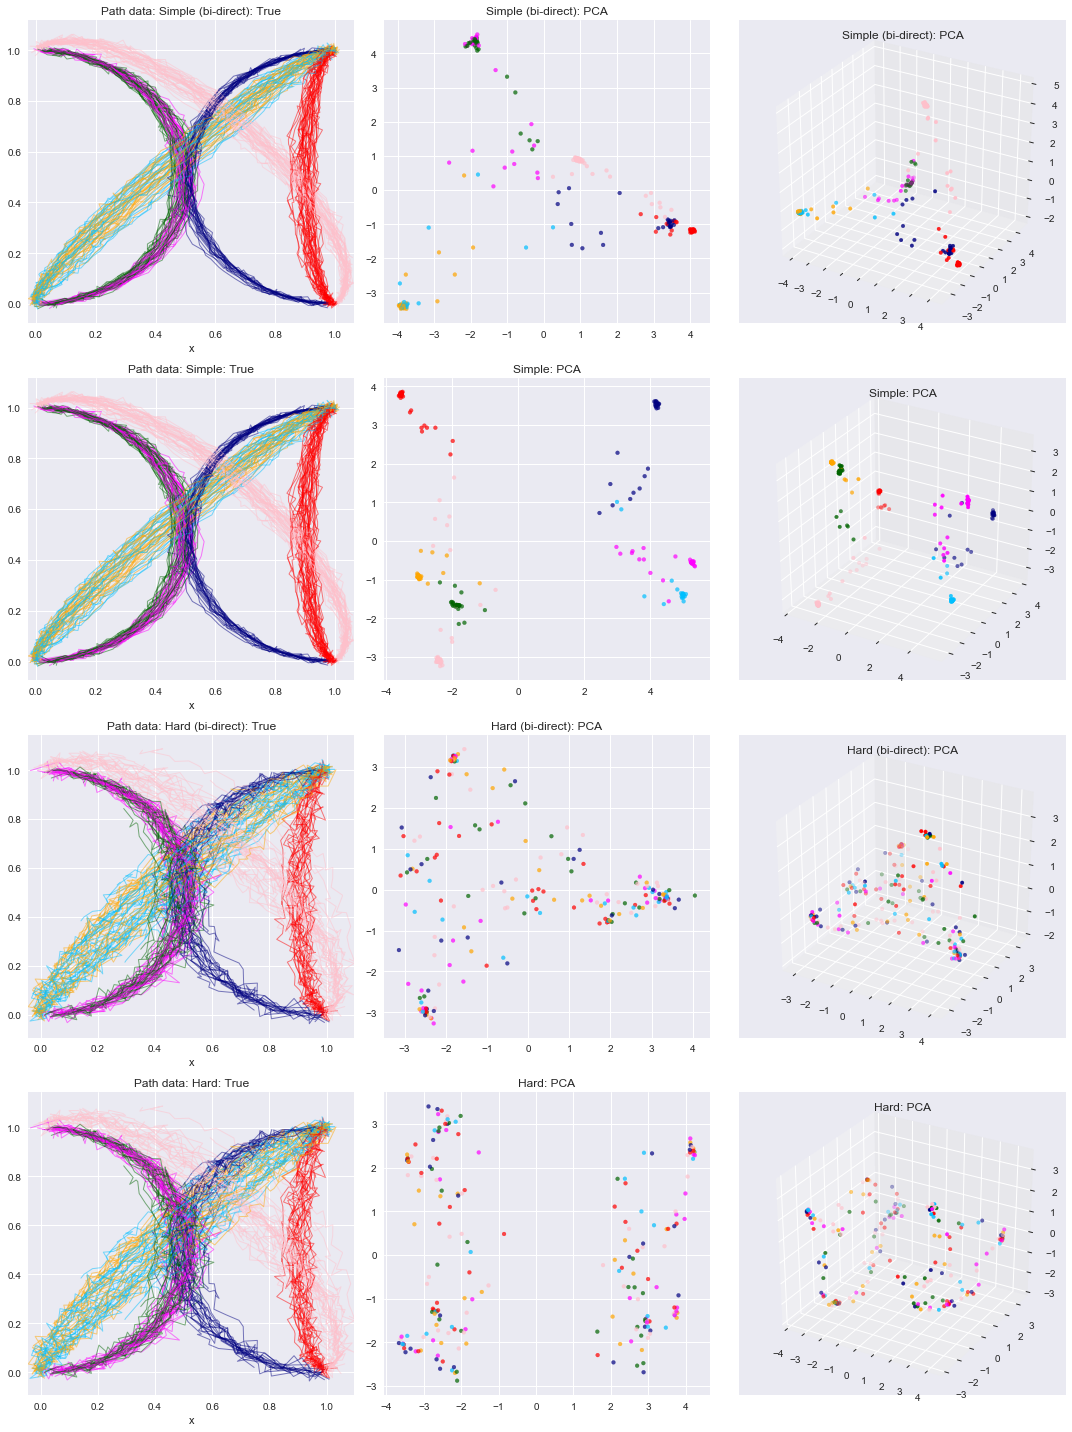

In [145]:
plot_path_data_embedding_all(
    embedding_obj=PCA(), embedding_name='PCA', 
    D_list=D_list, path_data_list=path_data_list, D_name_list=D_name_list
)

### Locally Linear Embedding (LLE)

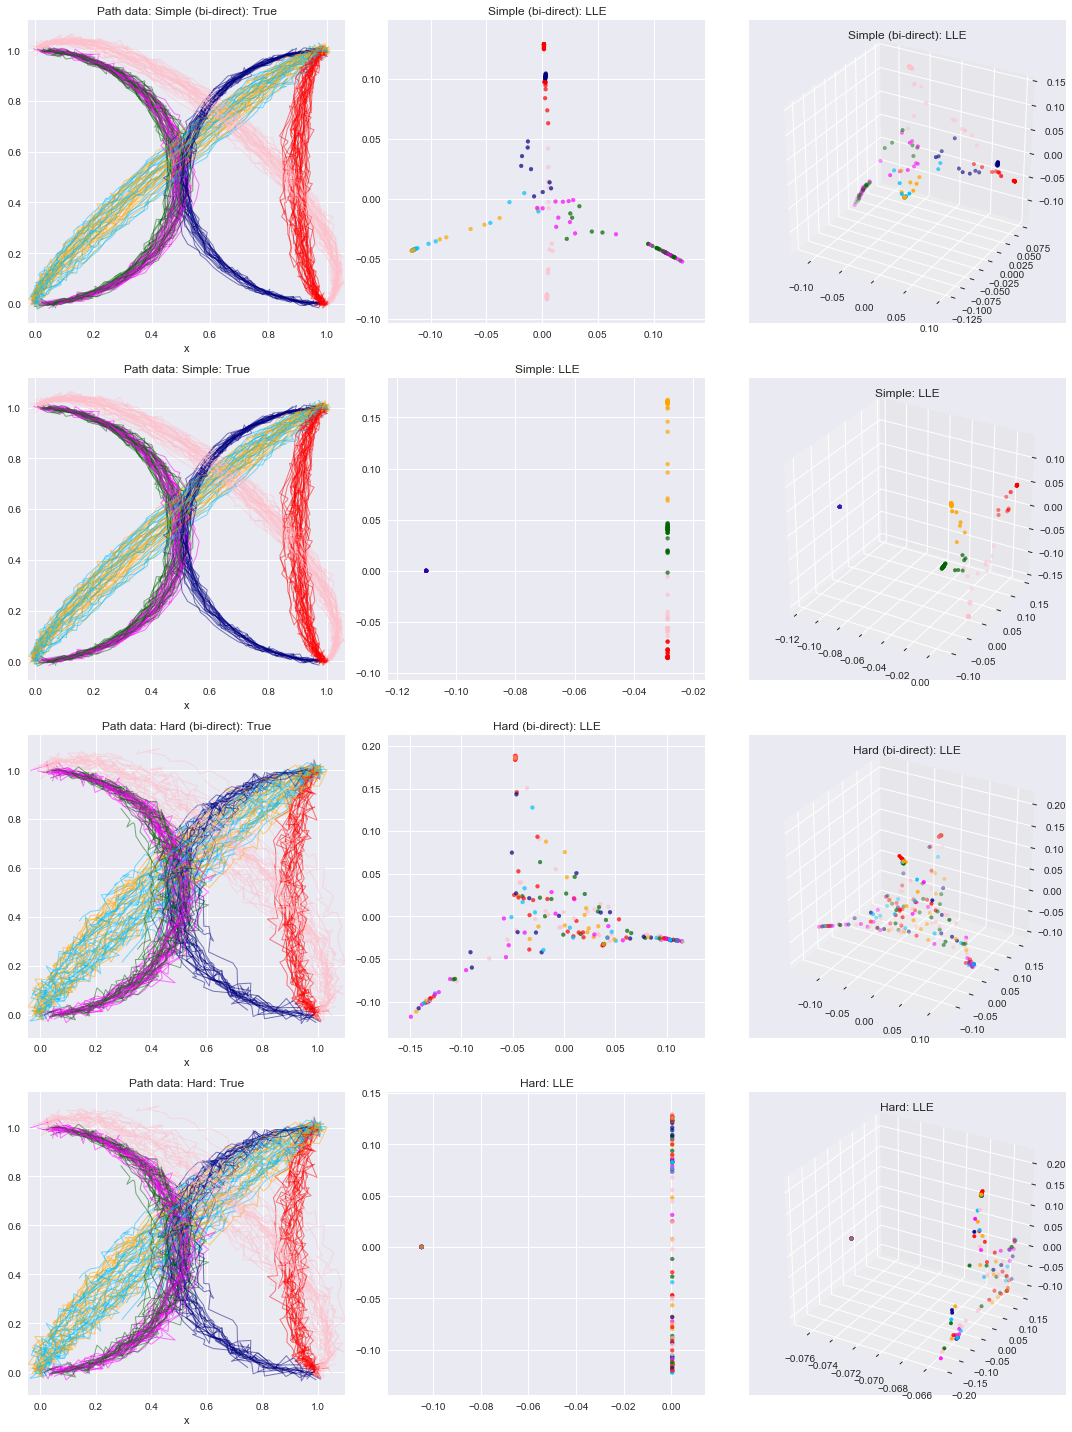

In [146]:
plot_path_data_embedding_all(
    embedding_obj=LocallyLinearEmbedding(n_neighbors=10, method='modified'), embedding_name='LLE',
    D_list=D_list, path_data_list=path_data_list, D_name_list=D_name_list
)

### Kernel PCA

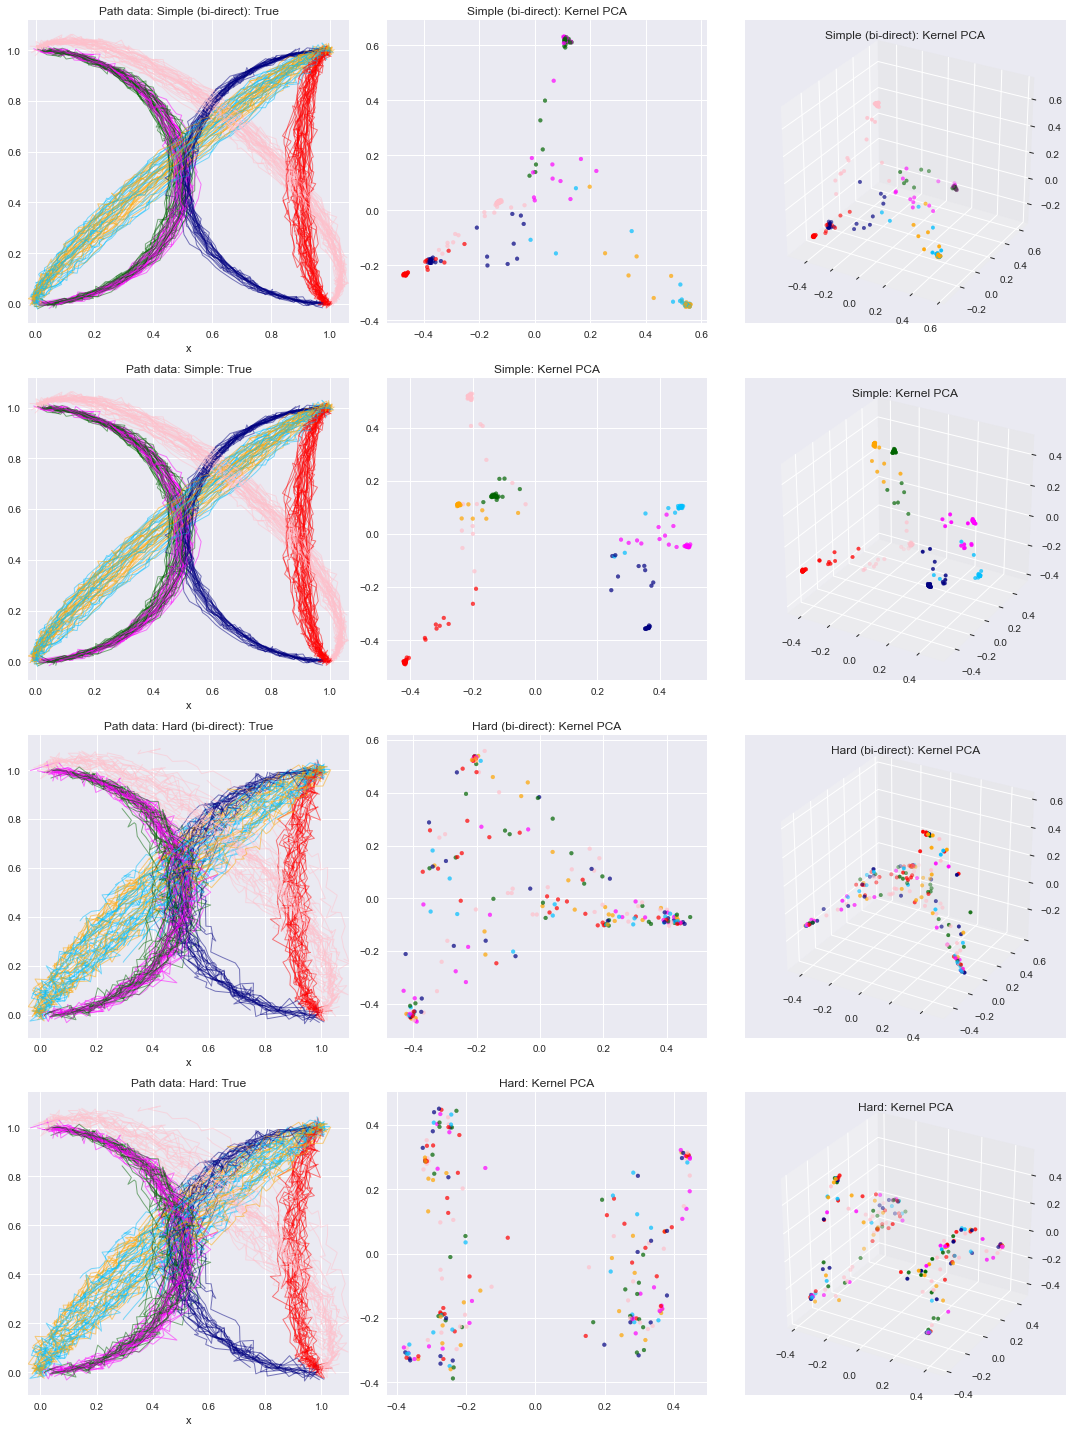

In [147]:
plot_path_data_embedding_all(
    embedding_obj=KernelPCA(kernel='precomputed'), embedding_name='Kernel PCA',
    D_list=[np.exp(-x*1.) for x in D_list], path_data_list=path_data_list, D_name_list=D_name_list
)

### Spectral Embedding

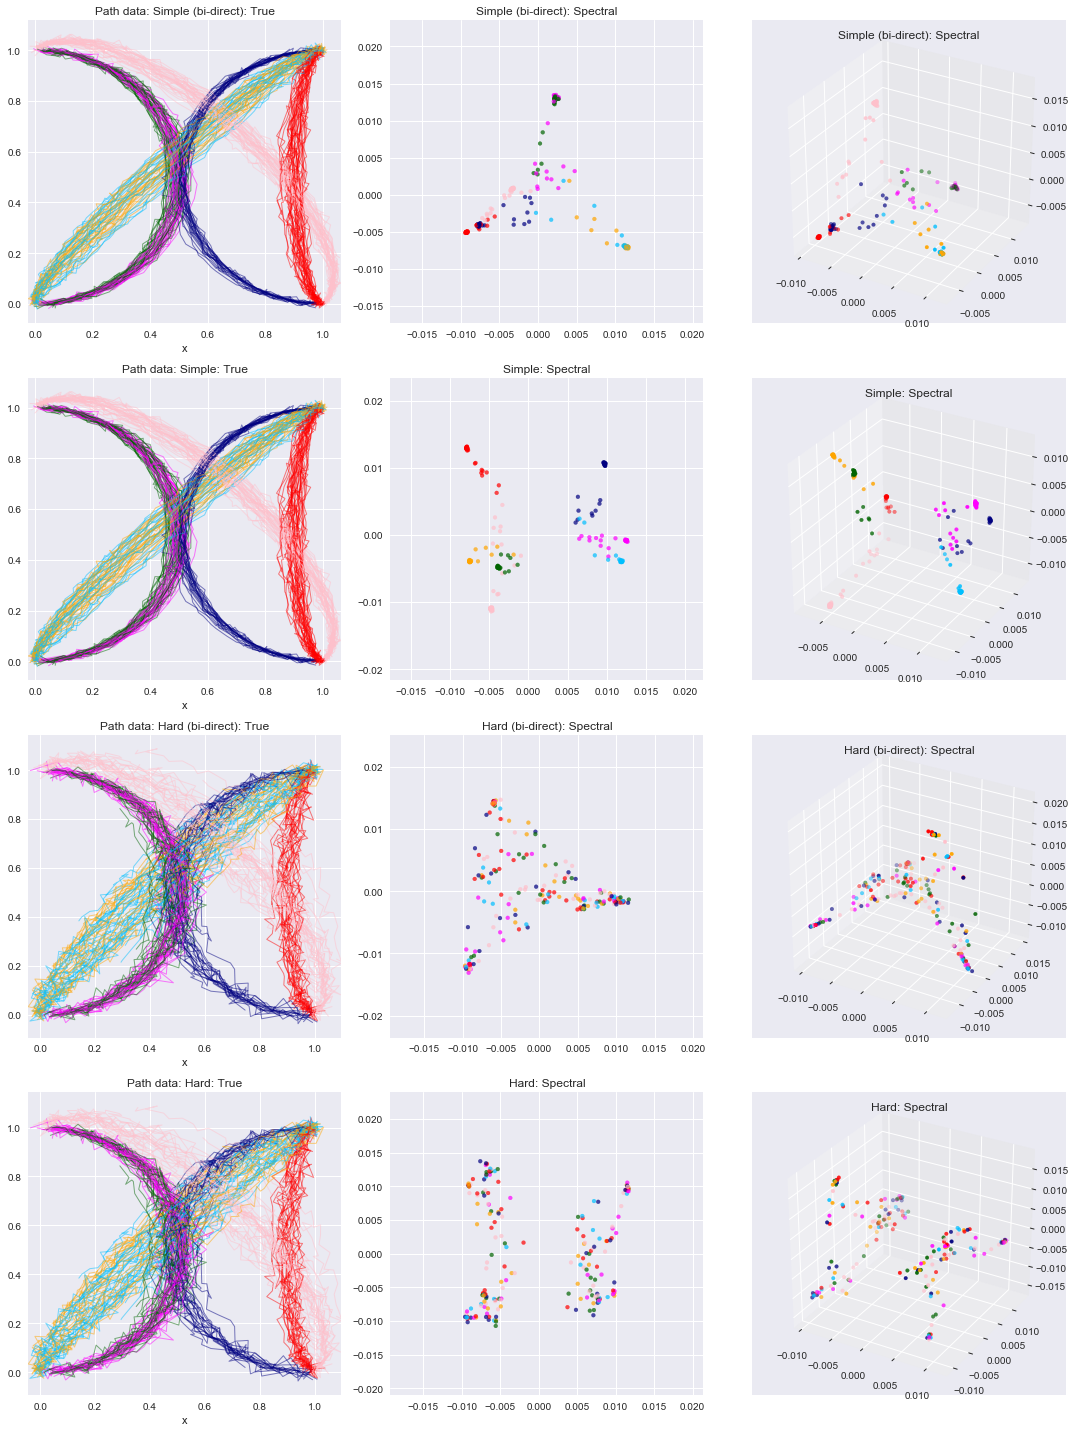

In [148]:
plot_path_data_embedding_all(
    embedding_obj=SpectralEmbedding(affinity='precomputed', n_neighbors=10), embedding_name='Spectral',
    D_list=[np.exp(-x*1.) for x in D_list], path_data_list=path_data_list, D_name_list=D_name_list
)

### Multidimensional Scaling (MDS)

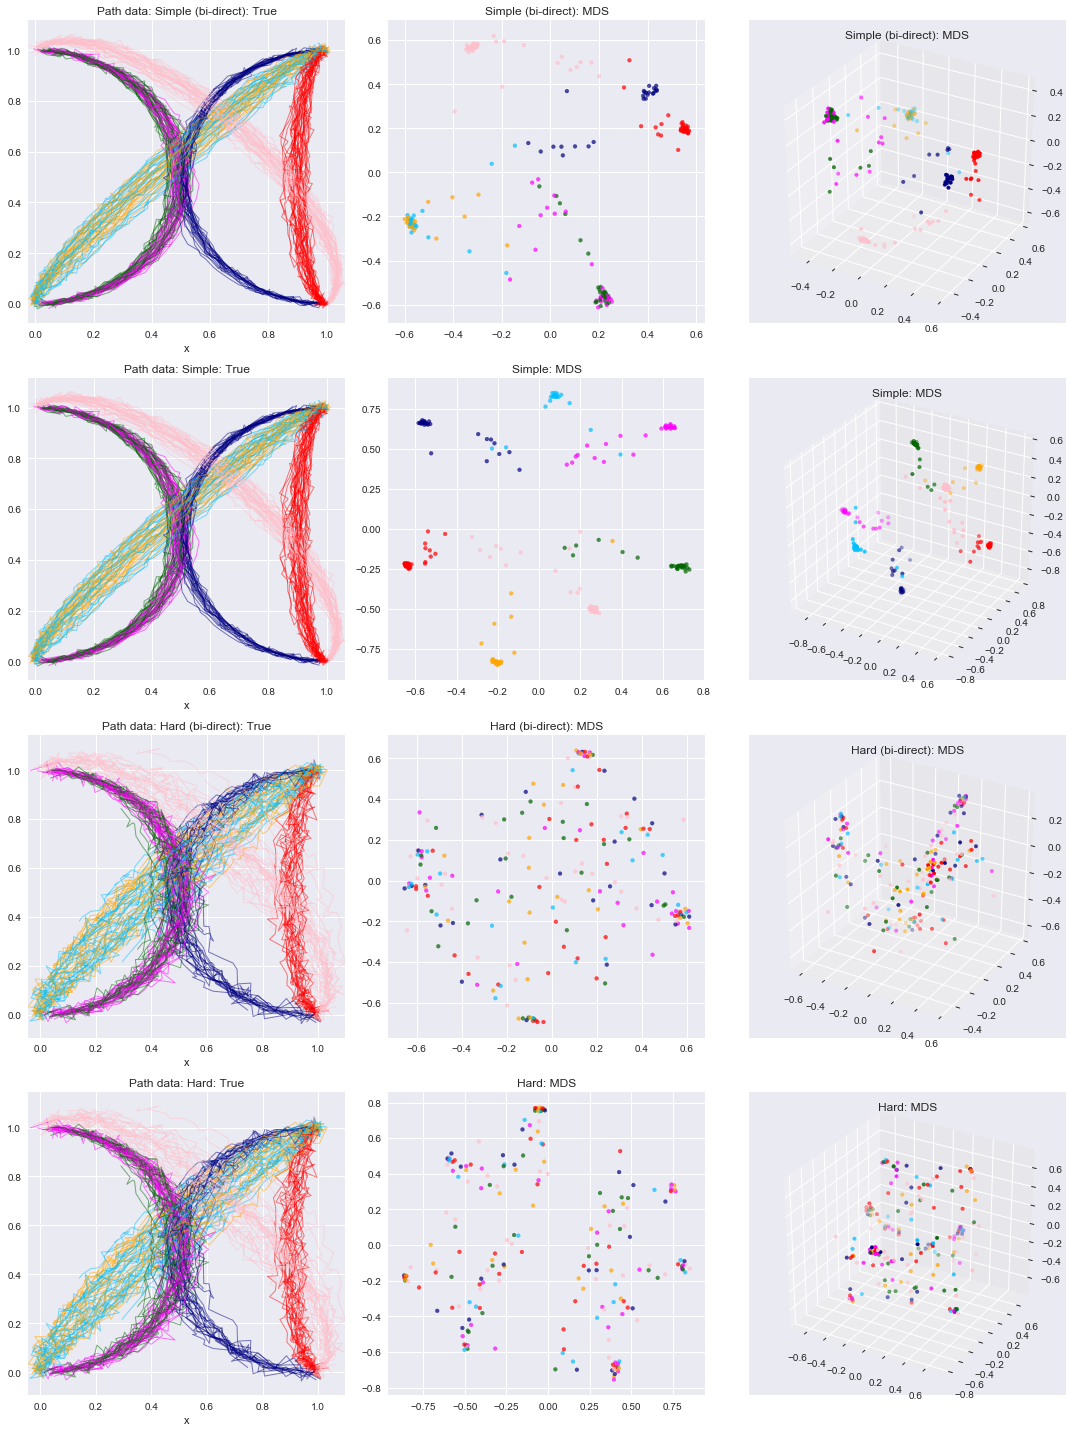

In [149]:
plot_path_data_embedding_all(
    embedding_obj=MDS(dissimilarity='precomputed'), embedding_name='MDS',
    D_list=D_list, path_data_list=path_data_list, D_name_list=D_name_list
)

## How did we do?

Dis we manage to identify all trading routes? Let's see:
- On the cleaner dataset, some embeddings did a bit better than others, but overall it is a success:
    - We can clearly identify 5 main trade routes.
    - We can clearly identify 7 main trade directions, which means that two trade routes serve for both import and export.
    - Interestingly, embeddings that are not designed to work with dissimilarity matrices (PCA and LLE) did well too.
- On the noisier dataset, all embeddings did rather poorly: embedding don't show clear patterns that we'd like to see in data.
    - Takeaway: Clean your data first. Here, we could remove partial paths - paths that start or end outside of any known city.
- 3D embeddings worked better than 2D.
    - Takeaway: Too many dimensions may add noise and obscure patterns in the data but too few may not be able to represent data well. Find the balance.
- Computation of dissimilarity matrix has quadratic complexity over the number of samples and can be quite slow. 
    - Takeaway: This is just something to keep in mind. And if you can optimize your distance function, it will help a lot.

# How to predict where a package is going?

Say, we used information about the trade routes to narrow area of attention for our surveillance system, so we could gather more and cleaner data about shipments. Now we'd like to be able to predict the package final destination when it's still on the way. How could we proceed? 

Let's take the following approach:
1. We randomly split data in ~~two~~ three parts.
2. We train an embedding algorithm on the first part of the data ("train 1"). Our observation data is clean so any embedding will probably work just fine.
3. In the second part of the data ("train 2"), 
    - for each path, we only keep the first half of the path and we drop the rest (that is information that will be available by the time we need to make a prediction);
    - we transform the new path using the trained embedding and store it as a feature;
    - we store the path endpoint - one of the four trade posts - as a label.
4. We train a classification model on the features and labels from the second part of the data.
5. Haven't we forgotten something? Of course! We must save a separate test set to evaluate performance of our model. That will be the third part of the data ("test"). We will process it exactly like the second part.

> Homework. Modify the model so it could predict where a package is being shipped at an arbitrary point, rather than only in the middle of its route. See how model accuracy varies depending on how many route points you can use for prediction.

## New clean shipment observations

The dataset is almost exactly the same as our previous "clean" dataset, with one change: we don't have partial routes anymore. All shipments are tracked from the very beginning to the very end.

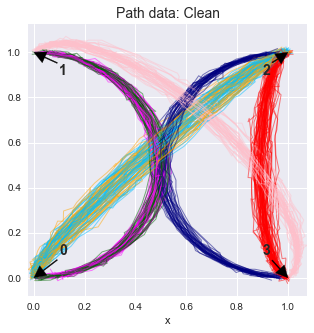

In [396]:
path_data_clean = generate_path_data(n=300, max_curve_sigma=0.02, noise_sigma=0.01, partial_proba=0, step=0.04)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_path_data(path_data_clean, 'Clean', ax=ax)

In [158]:
path_data_clean_train_1 = path_data_clean[:102]
path_data_clean_train_2 = path_data_clean[102:201]
path_data_clean_test = path_data_clean[201:]

for path in path_data_clean_train_2:
    path['xy'] = path['xy'][:len(path['xy']) // 2]
    
for path in path_data_clean_test:
    path['xy'] = path['xy'][:len(path['xy']) // 2]

## Dissimilarity matrix

Here, we are computing dissimilarity matrix using "default" Frechet distance that takes direction into account. For our classification problem, it makes a lot of sense.

Note that dissimilarity matrices for our features - shipment paths cut in the middle - are computed w.r.t. the full shipment paths on which we will train an embedding algorithm.

In [159]:
%%time
D_clean_train_1 = compute_distance_matrix(path_data_clean_train_1)
D_clean_train_2 = compute_distance_matrix_other(path_data_clean_train_2, path_data_clean_train_1)
D_clean_test = compute_distance_matrix_other(path_data_clean_test, path_data_clean_train_1)

Wall time: 3min 13s


In [160]:
print(D_clean_train_1.shape)
print(D_clean_train_2.shape)
print(D_clean_test.shape)

(102, 102)
(99, 102)
(99, 102)


## Classification

Let's try several modelling methods to solve this classification problem - just to be sure that we haven't missed something obvious:
- Kernel PCA (5 output dimensions) + Logistic Regression. Our previous analysis showed that 3 dimensions are sufficient to separate the trade routes - let's make it 5 just to be on the safe side.
- Kernel PCA (5 output dimensions) + Grading Boosting Trees. Gradient Boosting Trees should be able to find whatever Logistic Regression missed. Here I use `lightgbm`.
- No embedding + Logistic Regression. Logistic Regression is quite robust but not very flexible. Using a high-dimentional kernel matrix as feature might actually prove beneficial for this model.
- No embedding + SVM. Support Vector Machines are designed to work with kernel matrices directly. Let's see how they perform here.

### Kernel PCA + Logistic Regression

In [263]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

embedding_obj = KernelPCA(kernel='precomputed', n_components=5).fit(np.exp(-D_clean_train_1*1.))
X_train = embedding_obj.transform(D_clean_train_2)
y_train = np.array([x['end'] for x in path_data_clean_train_2])
X_test = embedding_obj.transform(D_clean_test)
y_test = np.array([x['end'] for x in path_data_clean_test])

m = LogisticRegression(
    multi_class='multinomial', 
    solver='lbfgs', 
    max_iter=1000,
)
m.fit(X_train, y_train)
y_train_hat = m.predict(X_train)
y_test_hat = m.predict(X_test)

print(f'accuracy (train) = {accuracy_score(y_train, y_train_hat):.4f}')
print(f'accuracy (test) = {accuracy_score(y_test, y_test_hat):.4f}')
ydf = pd.DataFrame(dict(y=y_test, yhat=y_test_hat), dtype=str).query('y!=yhat')
print((ydf['y'] + ydf['yhat']).value_counts().to_string())

accuracy (train) = 0.6364
accuracy (test) = 0.5051
03    33
12    15
32     1
Wall time: 20 ms


### Kernel PCA + Grading Boosting Trees

In [262]:
%%time
import lightgbm as lgb

embedding_obj = KernelPCA(kernel='precomputed', n_components=5).fit(np.exp(-D_clean_train_1*1.))
X_train = embedding_obj.transform(D_clean_train_2)
y_train = np.array([x['end'] for x in path_data_clean_train_2])
X_test = embedding_obj.transform(D_clean_test)
y_test = np.array([x['end'] for x in path_data_clean_test])

m = lgb.LGBMClassifier(
    n_estimators=100, 
    min_data_in_leaf=5,
    objective='cross_entropy',
    is_unbalance=False,
    num_leaves=5,
    learning_rate=0.01,
#     monotone_constraints=(1, 1, 1),
)
m.fit(X_train, y_train)
y_train_hat = m.predict(X_train)
y_test_hat = m.predict(X_test)

print(f'accuracy (train) = {accuracy_score(y_train, y_train_hat):.4f}')
print(f'accuracy (test) = {accuracy_score(y_test, y_test_hat):.4f}')
ydf = pd.DataFrame(dict(y=y_test, yhat=y_test_hat), dtype=str).query('y!=yhat')
print((ydf['y'] + ydf['yhat']).value_counts().to_string())

accuracy (train) = 0.9798
accuracy (test) = 0.8990
03    9
30    1
Wall time: 99 ms


### No embedding + Logistic Regression

In [260]:
%%time
X_train = D_clean_train_2
y_train = np.array([x['end'] for x in path_data_clean_train_2])
X_test = D_clean_test
y_test = np.array([x['end'] for x in path_data_clean_test])

m = LogisticRegression(
    multi_class='multinomial', 
    solver='lbfgs', 
    max_iter=1000,
)
m.fit(X_train, y_train)
y_train_hat = m.predict(X_train)
y_test_hat = m.predict(X_test)

print(f'accuracy (train) = {accuracy_score(y_train, y_train_hat):.4f}')
print(f'accuracy (test) = {accuracy_score(y_test, y_test_hat):.4f}')
ydf = pd.DataFrame(dict(y=y_test, yhat=y_test_hat), dtype=str).query('y!=yhat')
print((ydf['y'] + ydf['yhat']).value_counts().to_string())

accuracy (train) = 0.8687
accuracy (test) = 0.7980


03    9
30    7
12    4
dtype: int64

Wall time: 193 ms


### No embedding + SVM

In [237]:
%%time
D_clean_train_svm = compute_distance_matrix(path_data_clean_train_2)
D_clean_test_svm = compute_distance_matrix_other(path_data_clean_test, path_data_clean_train_2)

Wall time: 15.1 s


In [268]:
%%time
from sklearn.svm import SVC

X_train = np.exp(-D_clean_train_svm*1.)
y_train = np.array([x['end'] for x in path_data_clean_train_2])
X_test = np.exp(-D_clean_test_svm*1.)
y_test = np.array([x['end'] for x in path_data_clean_test])

m = SVC(
    kernel='precomputed',
    max_iter=1000,
)
m.fit(X_train, y_train)
y_train_hat = m.predict(X_train)
y_test_hat = m.predict(X_test)

print(f'accuracy (train) = {accuracy_score(y_train, y_train_hat):.4f}')
print(f'accuracy (test) = {accuracy_score(y_test, y_test_hat):.4f}')
ydf = pd.DataFrame(dict(y=y_test, yhat=y_test_hat), dtype=str).query('y!=yhat')
print((ydf['y'] + ydf['yhat']).value_counts().to_string())

accuracy (train) = 0.9495
accuracy (test) = 0.8889
03    10
30     1
Wall time: 9.01 ms


## How did we do?

Here is breakdown of model accuracy on the test set:
- Kernel PCA + Logistic Regression: 51%
- Kernel PCA + Grading Boosting Trees: **90%**
- No embedding + Logistic Regression: 80%
- No embedding + SVM: **89%**

Two best models - Kernel PCA + Grading Boosting Trees and SVM - scored around 90% even without hyper-parameter tuning! I'd say we did a pretty good job predicting the final package destination.

Why don't we have 100% accuracy? The model gets confused between the trade posts 0 and 3. There are trade route pairs that could be confusing for the model:
- 2 -> 0 vs. 2 -> 3
- 1 -> 0 vs. 1 -> 0

Still, visually these routes seem to be distinguishable by the time a package reaches the middle of its route. So, with hyper-parameter tuning, we could probably do better.

> Howework. Achieve at least 98% accuracy. Remember: whatever you do, DO NOT OVERFIT!

# Use case: Website Categories

Let's consider the following problem: we'd like to guess a category of website - educational, online shop, news, etc. - only by its domain name and front page. Here is an interesting article on how useful tree kernels could be for this problem: https://www.toptal.com/machine-learning/structured-data-tree-kernels

Now, what if we combine tree kernes with embeddings?

> Now, this whole use case will be your homework. Scrape some websites and learn how to categorize them. Think, what other problem you could solve knowing a website category? This is a very open-ended excercise. Improvise. Adapt. Overcome!

# Conclusion

We've come a long way. So, similarity matrix + embedding: was it worth it?

## Pros
- **The main advantage** of this approach allows to work with very complex data which you would not be able to use otherwise: all you need is to be able can compare two data samples.
- The output will be low-dimensional tabular numerical data, which you can feed in pretty much any model.

## Cons
- Using this approach, we will necessarily **lose some information**: 
    - first, when we replace original data with similarity matrix;
    - second, when we reduce dimensionality using an embedding.
- Computation of similarity matrix can be quite slow so we may need enough computational power - or patience.
- Certain embeddings are sensitive to very noise in data so additional data cleaning may be required.

## Alternatives: Why not just use...?
- Why not just use an embedding directly on data, not similarity matrix? If you know an embedding that you can use to efficiently encode your data directly - by all means, use it.
- Why not just use clusterisation on similarity matrix? If the only goal it to find clusters in a dataset, it would be totally okay to do so. Some clusterization methods leverage embeddings too - for example, Spectral Clustering.
- Why not just use similarity matrix as features? Unlike similarity matrix with the size $(n_{samples}, n_{samples})$, the output of similarity matrix + embedding will have the size $(n_{samples}, n_{components})$, where $n_{components} << n_{samples}$. The fewer dimensions we have, the easier it is to deal with data.
- Why not just use SVM with similarity matrix? SVM is a great model, which performed well in our Trade Route problem. However, there are three potential caveats:
    - SVM is specifically designed to deal with a kernel matrix. If our similarity matrix is not a kernel matrix (and often it might well not be), math doesn't work quite right, so we enter into a lightly shady territory.
    - If we'd like to add other features - which could be just simple numerical numbers - we won't be able to do it directly. We'd have to incorporate them in our similarity matrix and potentially lose some valuable information.
    - As good as SVM are, another model may work better for some particular problem.
- Why not just use Deep Learning? It is true: you can solve anything with the right neural network! Keep in mind, the process of finding, training, validating and deploying this neural network will not necesserily be a simple one... So, as always, use your best judgement!